In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BuildTardisData import linear_data
from BacktestStrategy_Rev import backtest_strategy

### Lags and delays for optimal accuracy

In [2]:
l, d = 1, 2

### Backtesting results for past 3 months data

In [3]:

def read_datasets():
    
    # Get all file names in the directory
    quotes, trades = os.listdir("D:\Quotes"), os.listdir("D:\Trades")
    
    # Loop through each file
    for quote, trade in zip(quotes, trades):
        
        file_path_q = os.path.join("D:\Quotes", quote)
        file_path_t = os.path.join("D:\Trades", trade)
            
        # Read the dataset using pandas
        df1 = pd.read_csv(file_path_q)
        df2 = pd.read_csv(file_path_t)
    
        # Yield combined dataset
        yield linear_data(df1, df2, l=l, d=d), quote[23:33]


We will be using one day's data to train the model and predict the next day.

**Assumptions:**
1. Initial Portfolio Value = $30,000
2. This includes the price to take one position at day open plus maintenance margin
3. Trade price equals Best Bid or Best ask depending on the position taken

### Profits for each trading day (Before Transaction Costs & Using Original MPB Formula) 

In [ ]:
Profits_dict = {}
comp_dict = {}
vol_dict = {}
datasets = read_datasets()
train, date = next(datasets)
for i in range(1,122):
    test, date = next(datasets)
    df = backtest_strategy(train, test, threshold=0.1, l=l, optimise=True)
    train = test
    Profits_dict[date] = df.iloc[-1,6]
    comp_dict[date] = (df.iloc[-1,5], sum(df["Trade Cost"]))
    vol_dict[date] = df.iloc[-1,3]

In [14]:
comp_dict

{'2022-12-29': (27455.68855400003, -6969.70000000095),
 '2022-12-30': (10624.009242000022, -5442.700000000164),
 '2022-12-31': (9216.920230000025, -2947.700000000441),
 '2023-01-01': (1965.8766399999997, -1206.800000000032),
 '2023-01-02': (4593.438122000001, -2425.899999999965),
 '2023-01-03': (12472.332179999983, -4838.000000000269),
 '2023-01-04': (15102.823483999991, -7005.800000000116),
 '2023-01-05': (14925.239994, -4395.7000000002445),
 '2023-01-06': (7843.805801999987, -3916.5000000001237),
 '2023-01-07': (3517.7151799999956, -1093.4000000000924),
 '2023-01-08': (85.44807599999999, -11.400000000008731),
 '2023-01-09': (26238.9399019999, -11100.500000000327),
 '2023-01-10': (19290.264658000044, -8299.70000000032),
 '2023-01-11': (21982.283567999963, -10237.600000000239),
 '2023-01-12': (179948.72761599967, -49203.600000003775),
 '2023-01-13': (231165.42105999897, -53818.60000000462),
 '2023-01-14': (384014.1515420015, -96064.69999999503),
 '2023-01-15': (239820.07484399984, -466

In [7]:
profits_df = pd.DataFrame(Profits_dict.values(), Profits_dict.keys(), columns=["Profit"])
profits_df

,Profit
2022-12-29,20485.988554
2022-12-30,5181.309242
2022-12-31,6269.220230
2023-01-01,759.076640
2023-01-02,2167.538122
...,...
2023-03-18,477318.456430
2023-03-19,496706.257610
2023-03-20,665955.128934
2023-03-21,489244.595378


In [8]:
vol_df = pd.DataFrame(vol_dict.values(), vol_dict.keys(), columns=["Volume"])
vol_df

,Volume
2022-12-29,11820
2022-12-30,4594
2022-12-31,3974
2023-01-01,848
2023-01-02,1966
...,...
2023-03-18,154780
2023-03-19,158128
2023-03-20,211190
2023-03-21,155680


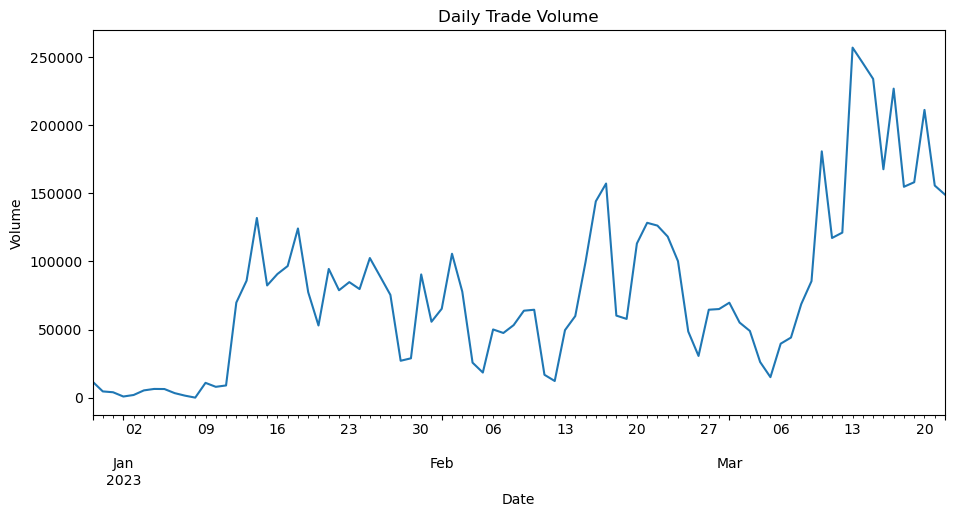

In [9]:
vol_df.index = pd.to_datetime(vol_df.index)
plt.title('Daily Trade Volume')
vol_df["Volume"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

### Portfolio Profit and Returns Graph

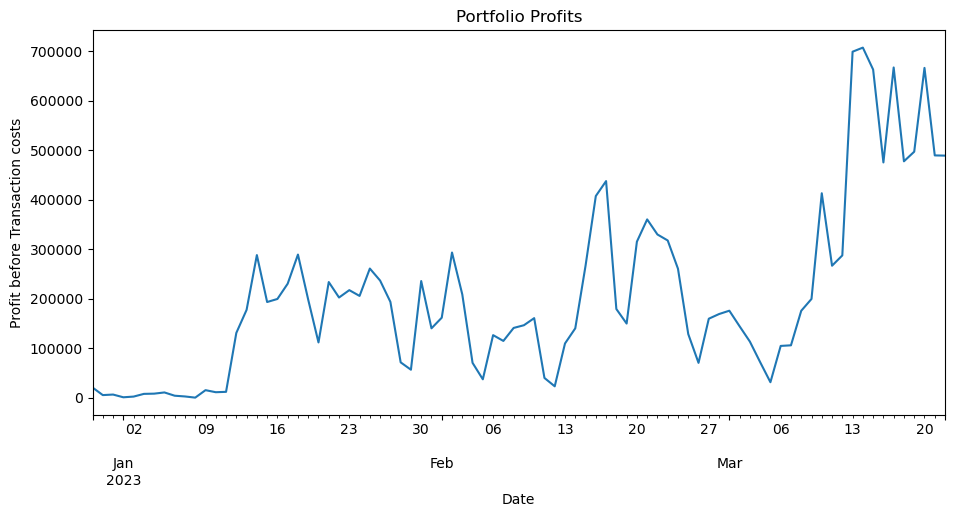

In [10]:
profits_df.index = pd.to_datetime(profits_df.index)
plt.title('Portfolio Profits')
profits_df["Profit"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Profit before Transaction costs')
plt.show()

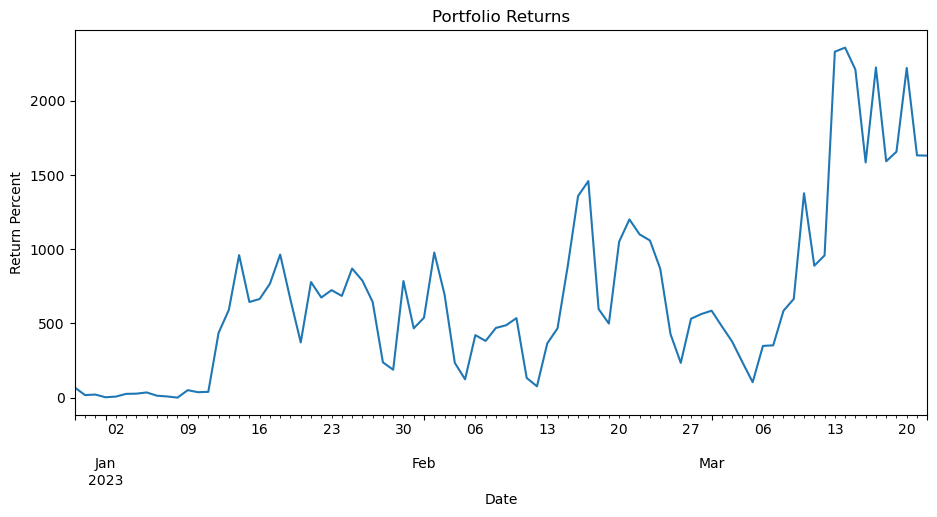

In [11]:
profits_df["Return Percent"] = (profits_df["Profit"]/30_000)*100
plt.title('Portfolio Returns')
profits_df["Return Percent"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Return Percent')
plt.show()

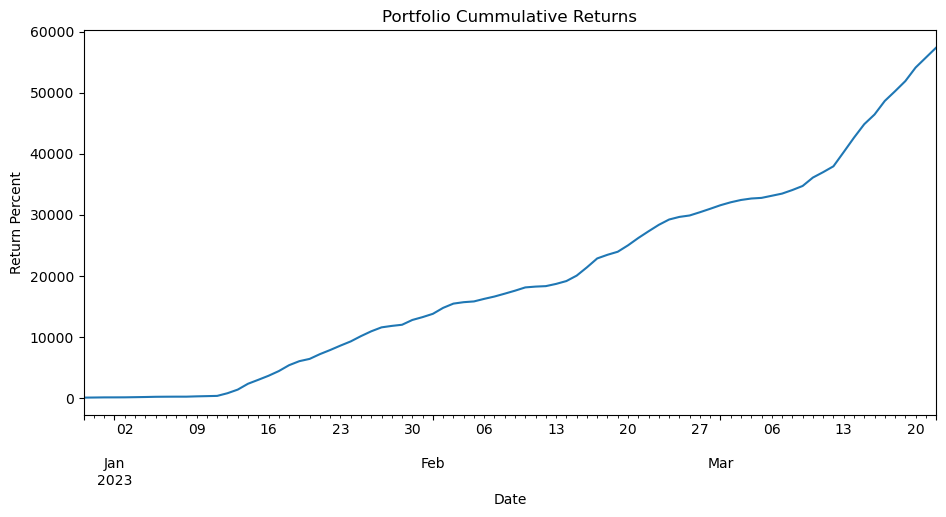

In [13]:
plt.title('Portfolio Cummulative Returns')
profits_df["Return Percent"].cumsum().plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Return Percent')
plt.show()

### Sharpe Ratio and Daily Drawdown

In [15]:
def calculate_sharpe_ratio(returns_data, risk_free_rate):
    
    # Calculate portfolio returns and volatility
    portfolio_returns = np.mean(returns_data)
    portfolio_volatility = np.std(returns_data)

    # Calculate excess returns
    excess_returns = portfolio_returns - risk_free_rate

    # Calculate Sharpe ratio
    sharpe_ratio = excess_returns / portfolio_volatility

    return sharpe_ratio

In [16]:
display("Sharpe Ratio of the Portfolio is:", calculate_sharpe_ratio(profits_df["Return Percent"], 4.5))

'Sharpe Ratio of the Portfolio is:'

1.148687491674722

Although, the strategy seems quite successfull, there is a lot of volatilty in the returns, the returns range from less than 5 percent to greater than 500, and therefore the sharpe ratio is rather low.

In [17]:
np.std(profits_df["Return Percent"])

590.6168546137293

### Given the dataset, I have chosen a rolling window of 7 days to calculate the daily drawdowns.

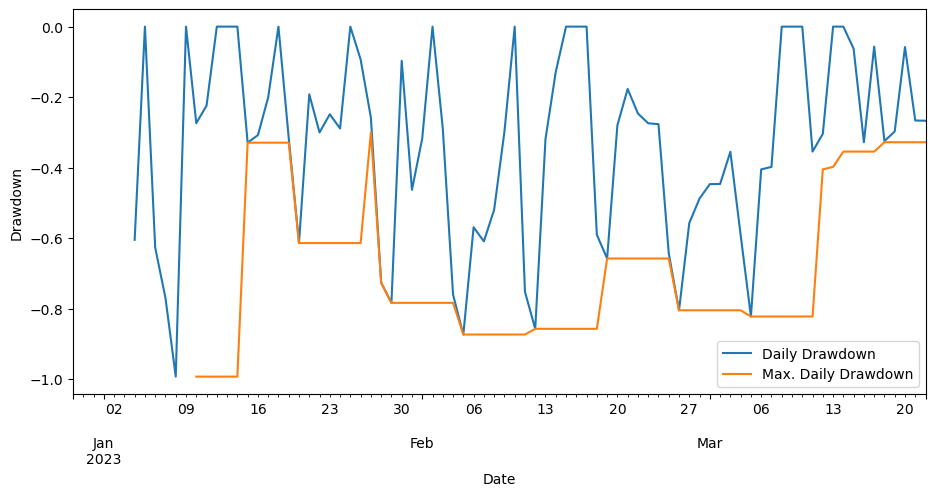

In [18]:
# We are going to use a trailing 1 trading day window
window = 7

# Calculate the max drawdown in the past window days for each day in the series.
Roll_Max = profits_df["Return Percent"].rolling(window).max()
Daily_Drawdown = profits_df["Return Percent"]/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window).min()

# Plot the results
Daily_Drawdown.plot(figsize=(11,5), label='Daily Drawdown')
Max_Daily_Drawdown.plot(figsize=(11,5), label='Max. Daily Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()